# Predictive modeling - Hyperparameter Tuning

In this section we apply techniquens for [hyperparameter tuning][1] on a real world data set, the _adult_ data set. The data set is avaialbe on the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) and can be assessed and downloaded [here](https://archive.ics.uci.edu/ml/datasets/Adult).

For the purpose of this tutorial we already downloaded the data set. You may fin it in the `datasets` folder (`../datasets/adult.csv`).

Please note that this tutorial bases on a talk given by [Olivier Grisel](https://github.com/ogrisel) and [Tim Head](https://github.com/betatim) at [EuroScipy 2017](https://www.euroscipy.org/2017/). You can watch their tutorial on YouTube ([Part I](https://www.youtube.com/watch?v=Vs7tdobwj1k&index=3&list=PL55N1lsytpbekFTO5swVmbHPhw093wo0h) and [Part II](https://www.youtube.com/watch?v=0eYOhEF_aK0&list=PL55N1lsytpbekFTO5swVmbHPhw093wo0h&index=2)).


[1]: https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)

**Import libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Global setting**

In [2]:
pd.options.display.max_columns = 200
plt.rcParams["figure.figsize"] = [12,6]

## Load the data

In [3]:
filepath = "../datasets/adult_data.txt"
names = ("age, workclass, fnlwgt, education, education-num, "
         "marital-status, occupation, relationship, race, sex, "
         "capital-gain, capital-loss, hours-per-week, "
         "native-country, income").split(', ')    
data = pd.read_csv(filepath , names=names)
data = data.drop('fnlwgt', axis=1)

We take a look at the first rows of the data set by calling the `head()` function.

In [4]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


> __The goal as stated in the auxillary file is to predict whether a person makes over 50K $ a year.__

## Training-Test Split

Split the data set into `target` and `feature` data sets.

In [5]:
target = data['income']
features_data = data.drop('income', axis=1)
features = pd.get_dummies(features_data)

print("Target variable: ", target.shape)
print("Features: ", features.shape)

Target variable:  (32561,)
Features:  (32561, 107)


In [6]:
X = features.values.astype(np.float32)
y = (target.values == ' >50K').astype(np.int32)

In [7]:
X.shape

(32561, 107)

In [8]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape)
print("Validation set: ", X_val.shape)

Training set:  (26048, 107)
Validation set:  (6513, 107)


## Learning Algorithm - Decision Trees

[__Decision Trees__](https://en.wikipedia.org/wiki/Decision_tree_learning) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


Some advantages of decision trees are:

* Simple to understand and to interpret (white box model). Trees can be visualised.
* Requires little data preparation.
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
* Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. See algorithms for more information.

The disadvantages of decision trees include:

* Decision-tree learners can create over-complex trees that do not generalise the data well. This is called [overfitting](https://en.wikipedia.org/wiki/Overfitting). 

* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.




In [10]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
print("ROC AUC Decision Tree: {:.4f} +/-{:.4f}".format(
      np.mean(scores), np.std(scores)))

ROC AUC Decision Tree: 0.8989 +/-0.0059


## Tuning your estimator

Hyper-parameters are not directly learnt by the classifier or regressor from the data. They need setting from the outside. An example of a hyper-parameter is `max_depth` for a decision tree classifier. In `scikit-learn` you can spot them as the parameters that are passed to the constructor of your estimator.

The best value of a hyper-parameter depends on the kind of problem you are solving:

* how many features and samples do you have?
* mostly numerical or mostly categorical features?
* is it a regression or classification task?

Therefore you should optimise the hyper-parameters for each problem, otherwise the performance of your classifier will not be as good as it could be.

### Search over a grid of parameters

This is the simplest strategy: you try every combination of values for each hyper-parameter. 
In scikit-learn __grid search__ is  provided by [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which exhaustively generates candidates from a grid of parameter values specified with the `param_grid`. 

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [1, 2, 4, 8, 16, 32]}

grid_search = GridSearchCV(clf, param_grid=param_grid, 
                           scoring='roc_auc', return_train_score=True)

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 4, 8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [14]:
type(grid_search)

sklearn.model_selection._search.GridSearchCV

Once we have created a `sklearn.model_selection._search.GridSearchCV` object we can access its attributes using the `.`-notation. For instance, the resutots of the cross-validatin are stroed un the `cv_results_` attribute.

In [15]:
grid_search.cv_results_

{'mean_fit_time': array([0.06760001, 0.09360019, 0.16120028, 0.23920027, 0.3432006 ,
        0.37366788]),
 'mean_score_time': array([0.        , 0.00520007, 0.00520007, 0.01040014, 0.00519999,
        0.00519991]),
 'mean_test_score': array([0.76059211, 0.83224861, 0.87059999, 0.89695122, 0.84696392,
        0.78051845]),
 'mean_train_score': array([0.76059206, 0.83303686, 0.87391964, 0.91660663, 0.96867707,
        0.99729411]),
 'param_max_depth': masked_array(data=[1, 2, 4, 8, 16, 32],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1},
  {'max_depth': 2},
  {'max_depth': 4},
  {'max_depth': 8},
  {'max_depth': 16},
  {'max_depth': 32}],
 'rank_test_score': array([6, 4, 2, 1, 3, 5]),
 'split0_test_score': array([0.75656757, 0.82948404, 0.86417978, 0.88960671, 0.84853001,
        0.78201692]),
 'split0_train_score': array([0.76260444, 0.83436907, 0.87276832, 0.91850856, 0.96899732,
        0

We print out the values of `max_depth` and the average train and test scores for each iteration.

In [16]:
for n, max_depth in enumerate(grid_search.cv_results_['param_max_depth']):
    print("Max depth: {}, train score: {:.3f}, test score {:.3f}".format(max_depth,
          grid_search.cv_results_['mean_train_score'][n],
          grid_search.cv_results_['mean_test_score'][n],))


Max depth: 1, train score: 0.761, test score 0.761
Max depth: 2, train score: 0.833, test score 0.832
Max depth: 4, train score: 0.874, test score 0.871
Max depth: 8, train score: 0.917, test score 0.897
Max depth: 16, train score: 0.969, test score 0.847
Max depth: 32, train score: 0.997, test score 0.781


For the prupose of model diagnsitcs we write a fucntion, `plot_grid_scores`, which allows us to compare test and train performance at for each value of of a particuarl hyperpartamer, such as `max_depth`. 


In [17]:
def plot_grid_scores(param_name, cv_result):
    # access the parameter
    param_values = np.array(cv_result["param_{}".format(param_name)])
    
    # plotting
    fix, ax = plt.subplots()

    ax.set_title("Scores for {}".format(param_name), size=18)
    ax.grid()
    ax.set_xlabel(param_name)
    ax.set_ylabel("Score")
    
    train_scores_mean = cv_result['mean_train_score']
    test_scores_mean = cv_result['mean_test_score']
    ax.scatter(param_values, train_scores_mean, s=80 ,marker='o', color="r",
                label="Training scores")
    ax.scatter(param_values, test_scores_mean, s=80, marker='o', color="g",
                label="Cross-validation scores")
    ax.legend(loc="best")
    print("Best test score: {:.4f}".format(np.max(test_scores_mean)))


Once implemtete we can use the `plot_grid_scores` and apply it on the `grid_search.cv_results_` object.

Best test score: 0.8970


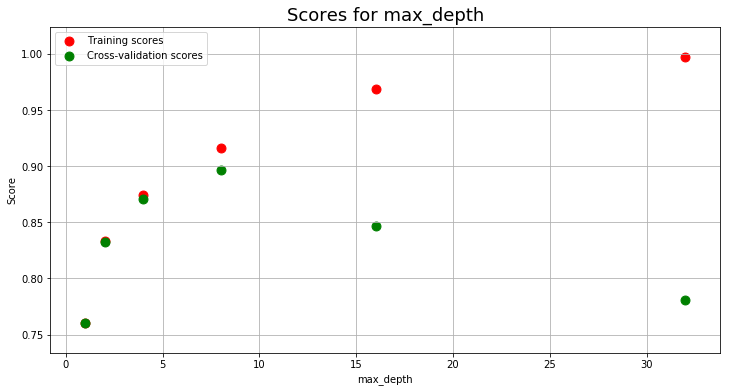

In [18]:
plot_grid_scores("max_depth", grid_search.cv_results_)

>**Challenge:** Extend the parameter grid to also search over different values for the `max_features` hyper-parameter. (Try: 3, 6, 12, 24, 48, and 96). PLot the reultus usign the `plot_grid_scores` function from above.

In [19]:
%%writefile ../src/_solutions/gridsearch.py
param_grid = {"max_depth": [1, 2, 4, 8, 16, 32],
              'max_features': [3, 6, 12, 24, 48, 96]}
grid_search = GridSearchCV(clf, param_grid=param_grid, 
                           scoring='roc_auc', return_train_score=True)

grid_search.fit(X_train, y_train)
print(grid_search)

Overwriting ../src/_solutions/gridsearch.py


In [20]:
# %load ../src/_solutions/gridsearch.py
param_grid = {"max_depth": [1, 2, 4, 8, 16, 32],
              'max_features': [3, 6, 12, 24, 48, 96]}
grid_search = GridSearchCV(clf, param_grid=param_grid, 
                           scoring='roc_auc', return_train_score=True)

grid_search.fit(X_train, y_train)
print(grid_search)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 4, 8, 16, 32], 'max_features': [3, 6, 12, 24, 48, 96]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)


Best test score: 0.8966


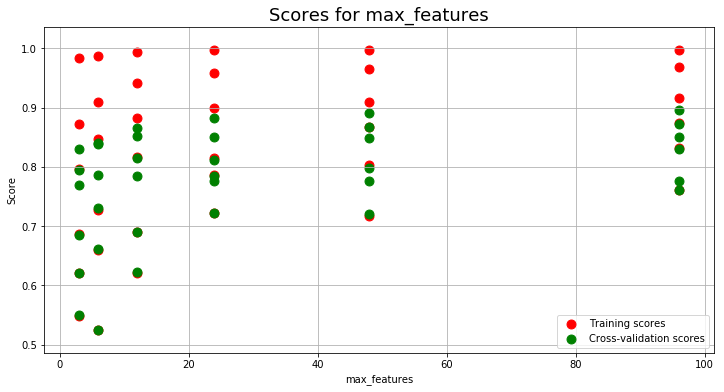

In [21]:
plot_grid_scores("max_features", grid_search.cv_results_)

Another inertsing infoatmion might be to cosenr the the best three parameter combinations so far. We write a fiunction called `report` to achieve tis task.

In [22]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))            

In [23]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.897 (std: 0.003)
Parameters: {'max_depth': 8, 'max_features': 96}

Model with rank: 2
Mean validation score: 0.890 (std: 0.003)
Parameters: {'max_depth': 8, 'max_features': 48}

Model with rank: 3
Mean validation score: 0.882 (std: 0.003)
Parameters: {'max_depth': 8, 'max_features': 24}



### Random grid search

An alternative to the exhaustive grid search is to sample parameter values at random. This has two main benefits over an exhaustive search:
* A budget can be chosen independent of the number of parameters and possible values.
* Adding parameters that do not influence the performance does not decrease efficiency.

[`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by `n_iter`.


In [24]:
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV

param_grid = {"max_depth": sp_randint(1, 32),
              "max_features": sp_randint(1, 96),
             }
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=36, scoring='roc_auc', return_train_score=True)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=36, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000A5E8400>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000A5E84A8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

Best test score: 0.8938


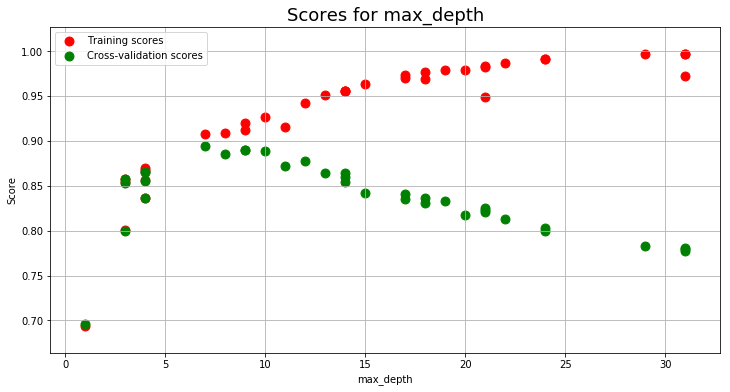

In [25]:
plot_grid_scores("max_depth", random_search.cv_results_)

For the same number of model evaluations you get a much better view of how the performance varies as a function of `max_depth`. This is a big advantage especially if one of the hyper-parameters does not influence the performance of the estimator. Though as you increase the number of dimensions making a projection into just one becomes more noisy.

In [26]:
param_grid = {"max_depth": sp_randint(1, 32),
              "max_features": sp_randint(1, 96),
              "min_samples_leaf": sp_randint(15, 40)
             }
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=36, scoring='roc_auc', return_train_score=True)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=36, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000A3F2E80>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000A3F2748>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000A6039B0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

Best test score: 0.9033


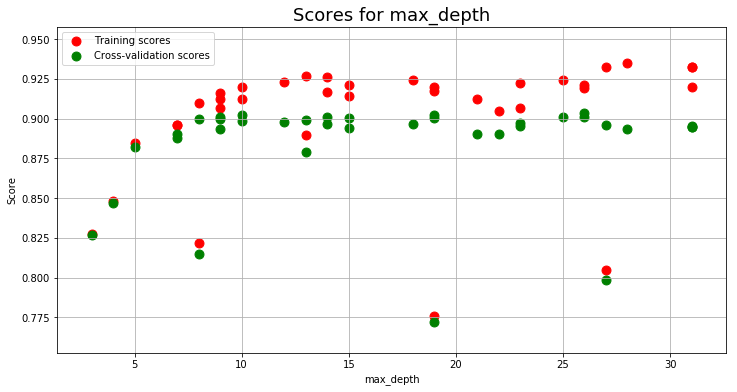

In [27]:
plot_grid_scores("max_depth", random_search.cv_results_)

Best test score: 0.9033


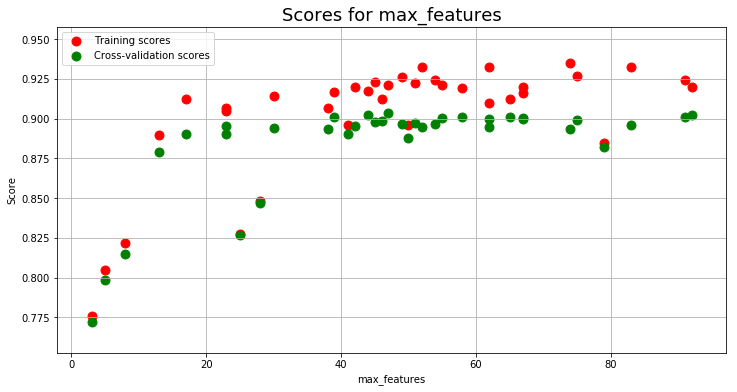

In [28]:
plot_grid_scores("max_features", random_search.cv_results_)

Best test score: 0.9033


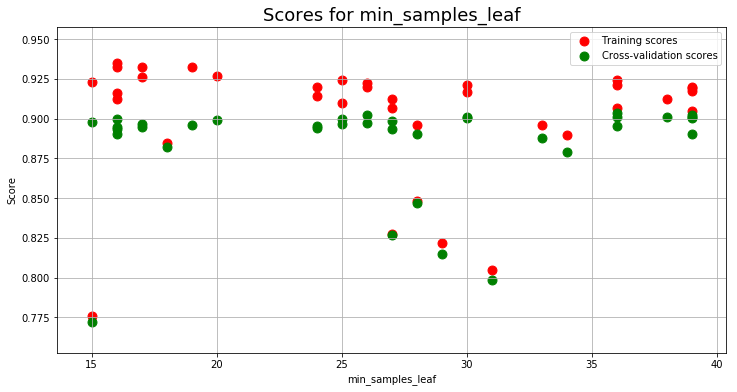

In [29]:
plot_grid_scores("min_samples_leaf", random_search.cv_results_)

You may assess the best performing paramter combiateion usnt the `best_params_` attribute. 

In [30]:
random_search.best_params_

{'max_depth': 26, 'max_features': 47, 'min_samples_leaf': 36}

### Bayesian optimisation

Neither the exhaustive grid search nor random search adapt their search for the best hyper-parameter as they evaluate points. For the grid all points are chosen upfront, and for random search all of them are chosen at random.

It makes sense to use the knowledge from the first few evaluations to decide what hyper-parameters to try next. This is what tools like [`scikit-optimize`](https://scikit-optimize.github.io/) try and do. The technique is known as bayesian optimisation or sequential model based optimisation.

The basic algorithm goes like this:
* evaluate a new set of hyper-parameters
* fit a regression model to all sets of hyper-parameters
* use the regression model to predict which set of hyper-parameters is the best
* evaluate that set of hyper-parameters
* repeat.

`scikit-optimize` provides a drop-in replacement for `GridSearchCV` and `RandomSearchCV` that performs all this on the inside:

_Note that if `scikit-optimize` is not yet installed on your machine type `conda install scikit-optimize` into your shell._ 

In [31]:
from skopt import BayesSearchCV

In [32]:
bayes_search = BayesSearchCV(
    clf,
    {"max_depth": (1, 32),
     "max_features": (1, 96),
     "min_samples_leaf": (15, 40)
    },
    n_iter=15,
    scoring='roc_auc',
    return_train_score=True
)

In [33]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_iter=15, n_jobs=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=True, scoring='roc_auc',
       search_spaces={'max_depth': (1, 32), 'max_features': (1, 96), 'min_samples_leaf': (15, 40)},
       verbose=0)

Once the compuation finisd, we can assecct the resukts in the same fdashi as we did before.

Best test score: 0.9023


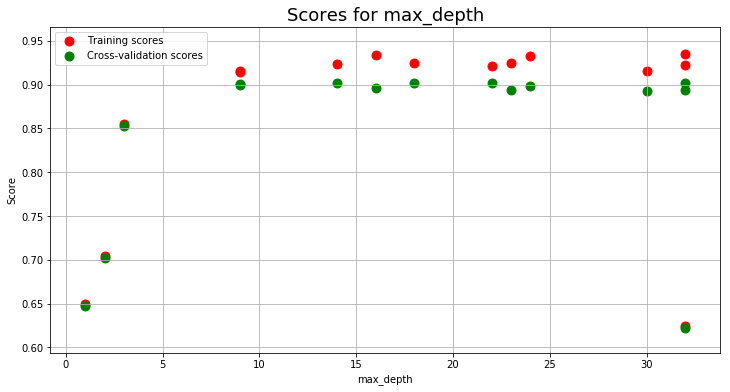

In [34]:
plot_grid_scores("max_depth", bayes_search.cv_results_)

In [35]:
bayes_search.best_params_

{'max_depth': 14, 'max_features': 96, 'min_samples_leaf': 33}

In [36]:
bayes_search.best_score_

0.9023061334808244

In [37]:
np.mean(bayes_search.cv_results_["mean_test_score"])

0.8472437571094711

## Using cross validation results for predcitions

Once we terminetd out hyperparatnmer seach we may actuallkw want to use the best mode for predictions. Note that we did not actually build a test set, hence for the pruors of dementsosnwe use the validatainset as test set:

In [38]:
X_test = X_val
y_test = y_val

We use accuary as our model evaluautin metric.

In [39]:
from sklearn.metrics import accuracy_score

Now there is  ore than one way to make proidetzin for a hold oput set (`X_test`). We may use the `best_estimator_` to build an estimatior, or use the `predict` diectyl on the CV-object.

In [40]:
# variante 1
m = bayes_search.best_estimator_
y_pred_v1 = m.fit(X_train, y_train).predict(X_test)
print("Accurarvy on the test set: ", accuracy_score(y_true=y_test, y_pred=y_pred_v1))

Accurarvy on the test set:  0.8642714570858283


In [41]:
# variante 2
y_pred_v2 = bayes_search.predict(X_val)
print("Accurarvy on the test set: ", accuracy_score(y_true=y_test, y_pred=y_pred_v2))

Accurarvy on the test set:  0.8642714570858283


The resukts should be the same.